In [ ]:
!pip install pymorphy2
!pip install nltk
!pip install squarify
!pip install faker
!pip install keybert

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import random
from faker import Faker
from datetime import datetime, timedelta
import uuid
import datetime
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from umap import UMAP



In [102]:
# Загрузка данных
df = pd.read_excel('L_corrected1.xlsx')

# После завершения обработки сохраните результат
#df.to_csv('L.csv', index=False, encoding='utf-8-sig')

In [103]:
# 1. Удаление полных дубликатов
print(f"Исходное количество строк: {len(df)}")
df = df.drop_duplicates()
print(f"После удаления дубликатов: {len(df)}")

# 2. Удаление пустых описаний
df = df[df['Desc'].notna() & (df['Desc'].astype(str).str.strip() != '')]
print(f"После удаления пустых описаний: {len(df)}")

Исходное количество строк: 50988
После удаления дубликатов: 50988
После удаления пустых описаний: 50988


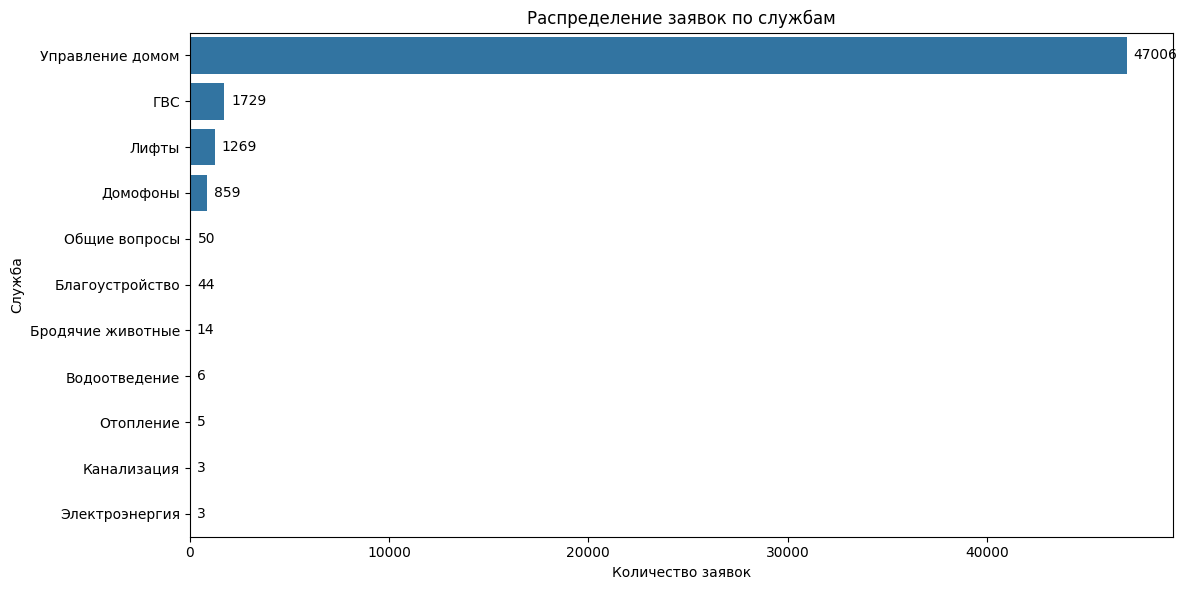

In [104]:
# 1. Анализ распределения заявок
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, y='Group', order=df['Group'].value_counts().index)
plt.title('Распределение заявок по службам')
plt.xlabel('Количество заявок')
plt.ylabel('Служба')

# Добавление аннотаций с количеством
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height()/2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.tight_layout()
plt.savefig('service_distribution.png', dpi=300)
plt.show()


In [109]:
# Списки ключевых слов для классификации
water_supply_keywords = [
    'хвс', 'гвс', 'водоснабжени', 'горячая вода', 'холодная вода',
    'труба вод', 'напор воды', 'давление воды', 'нет воды', 'отсутствует вода',
    'слабый напор', 'течет вода', 'протечка воды', 'счетчик воды', 'счётчик воды',
    'трубопровод вод', 'водопровод', 'краны вод', 'кран вод', 'смеситель',
    'бойлер', 'водонагреватель', 'змеевик', 'отсутствует хвс', 'отсутствует гвс',
    'нет хвс', 'нет гвс', 'течь хвс', 'течь гвс', 'порыв трубы хвс',
    'порыв трубы гвс', 'течь трубы хвс', 'течь трубы гвс'
]

water_drain_keywords = [
    'канализац', 'засор', 'кнс', 'слив', 'сточные воды', 'водоотведен',
    'запах канализации', 'забилась', 'протечка канализации', 'засорилась',
    'затопление канализации', 'затопление кнс', 'ливневка', 'ливнёвка',
    'ливневая канализация', 'дождевая канализация', 'стояк кнс', 'труба кнс'
]

electricity_keywords = [
    'электричеств', 'электроэнерги', 'свет', 'лампочк', 'розетк', 'выключател',
    'проводк', 'счетчик электро', 'счётчик электро', 'автомат', 'короткое замыкание',
    'искрит', 'нет света', 'отсутствует свет', 'перебои с электричеством',
    'эл.снабжение', 'эл.энергия', 'электрический', 'светильник', 'патрон',
    'эл.щиток', 'электрощит', 'электропроводка', 'электролиния', 'электрокабель',
    'свет отсутствует', 'свет не горит', 'не работает свет', 'отключение электричества',
    'отключение света', 'электроэнергия отключена', 'электричество отключено',
    'эл.счетчик', 'эл счетчик', 'электрический счетчик', 'электроэнерги',
    'электричеств', 'счетчик электроэнергии', 'счётчик электроэнергии'
]

def classify_group(desc, cat):
    combined_text = f"{desc} {cat}".lower()

    for keyword in water_drain_keywords:
        if keyword in combined_text:
            return 'Водоотведение'

    for keyword in water_supply_keywords:
        if keyword in combined_text:
            return 'Канализация'

    for keyword in electricity_keywords:
        if keyword in combined_text:
            return 'Электроэнергия'

    return None


df_copy = df.copy()

classified_groups = df_copy.apply(
    lambda row: classify_group(row['Desc'], row['Cat']) if row['Group'] == 'Управление домом' else None,
    axis=1
)


df_copy.loc[classified_groups.notna(), 'Group'] = classified_groups[classified_groups.notna()]


df_copy.to_csv('L_corrected.csv', index=False)
print("Файл 'L_corrected.xlsx' успешно обновлен.")

Файл 'L_corrected.xlsx' успешно обновлен.


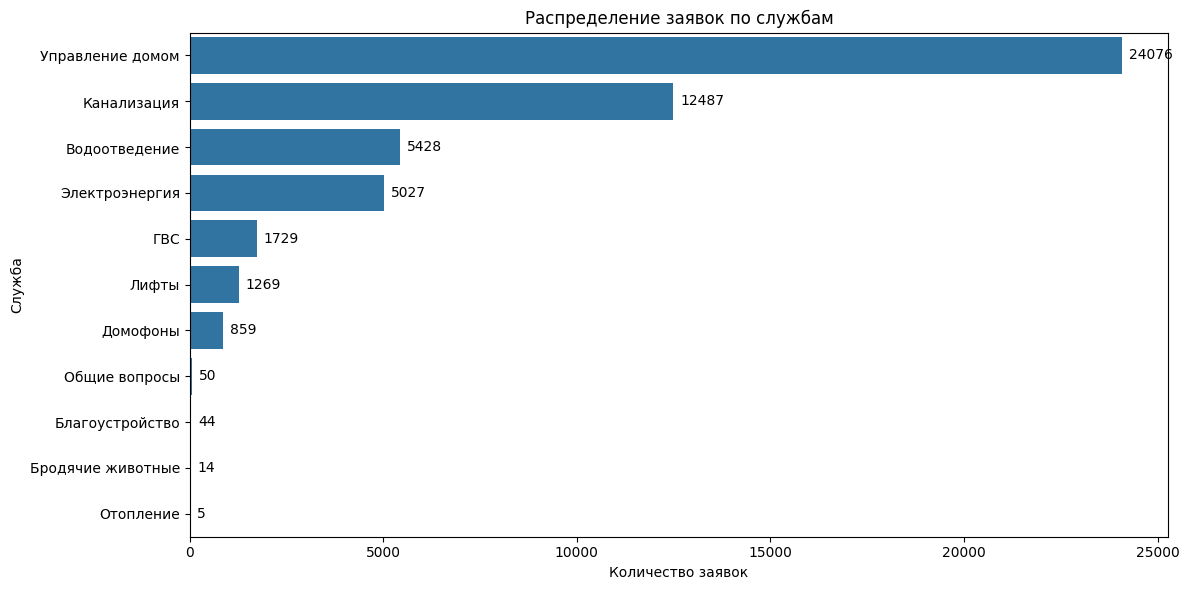

In [108]:

# 1. Анализ распределения заявок
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_copy, y='Group', order=df_copy['Group'].value_counts().index)
plt.title('Распределение заявок по службам')
plt.xlabel('Количество заявок')
plt.ylabel('Служба')

# Добавление аннотаций с количеством
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height()/2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.tight_layout()
plt.savefig('service_distribution_new.png', dpi=300)
plt.show()


In [ ]:
expanded_df = df_filtered.copy()
# 4. Очистка текста с сохранением технических терминов
# Инициализация стеммера для русского языка
stemmer = SnowballStemmer("russian")

# Загрузка русских стоп-слов
try:
    stop_words = set(stopwords.words('russian'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('russian'))

technical_terms = {'гвс', 'хвс', 'кнс', 'цо', 'эл', 'сч', 'тэц', 'укс', 'ипу', 'двк', 'ук'}

def clean_text(text):
    text = str(text).lower()

    # Сохранение технических аббревиатур
    text = re.sub(r'\b(гвс|хвс|кнс|цо|эл|сч|тэц|укс|ипу|двк|ук)\b',
                lambda m: m.group(1), text)

    # Очистка текста
    text = re.sub(r'[^а-яё0-9\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)  # Удаление чисел
    text = re.sub(r'\s+', ' ', text).strip()

    # Стемминг
    tokens = []
    for token in text.split():
        if token in technical_terms:
            tokens.append(token)
        elif len(token) > 2 and token not in stop_words:
            stem = stemmer.stem(token)
            tokens.append(stem)

    return ' '.join(tokens)

expanded_df['Clean_Desc'] = expanded_df['Desc'].apply(clean_text)

# 5. TF-IDF векторизация
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85
)

tfidf_matrix = tfidf.fit_transform(expanded_df['Clean_Desc'])

# 6. Сохранение результатов
# Весь датасет со всеми колонками
expanded_df.to_csv('full_cleaned_dataset.csv', index=False)

# TF-IDF матрица
import scipy.sparse
scipy.sparse.save_npz('tfidf_matrix.npz', tfidf_matrix)

# Названия фичей TF-IDF
with open('tfidf_features.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(tfidf.get_feature_names_out()))

print("Предобработка завершена. Результаты сохранены.")

Предобработка завершена. Результаты сохранены.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec
from scipy.stats import chi2_contingency
import squarify
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных и удаление ненужных столбцов
df = pd.read_csv('full_cleaned_dataset.csv')
df.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], inplace=True, errors='ignore')

# Преобразование даты с обработкой ошибок
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 1. Расширенный анализ структуры данных
print("="*80)
print("ПОЛНЫЙ АНАЛИЗ СТРУКТУРЫ ДАННЫХ")
print("="*80)

# Создаем сводную таблицу для анализа структуры
structure_analysis = pd.DataFrame({
    'Тип данных': df.dtypes,
    'Уникальные значения': df.nunique(),
    'Пропуски': df.isnull().sum(),
    '% пропусков': (df.isnull().mean() * 100).round(1)
})
print(structure_analysis)

# Визуализация пропущенных данных
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Распределение пропущенных значений в датасете', fontsize=16)
plt.tight_layout()
plt.savefig('missing_data_heatmap.png', dpi=300)
plt.close()

# 2. Углубленный анализ временных характеристик
print("\n" + "="*80)
print("УГЛУБЛЕННЫЙ ВРЕМЕННОЙ АНАЛИЗ")
print("="*80)

# Создание временных признаков
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Создаем комплексную фигуру для временного анализа
plt.figure(figsize=(18, 20))
gs = gridspec.GridSpec(4, 2)

# Динамика обращений по годам
ax0 = plt.subplot(gs[0, 0])
yearly_counts = df.groupby('Year').size()
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o', color='#1f77b4')
plt.title('Динамика обращений по годам', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество обращений', fontsize=12)
plt.grid(True, alpha=0.3)

# Сезонность по месяцам
ax1 = plt.subplot(gs[0, 1])
monthly_counts = df.groupby('Month').size()
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, color='#2ca02c')
plt.title('Сезонность обращений по месяцам', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество обращений', fontsize=12)
plt.xticks(range(0, 12), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])

# Распределение по времени суток
ax2 = plt.subplot(gs[1, 0])
hourly_counts = df.groupby('Hour').size()
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='#d62728')
plt.title('Распределение по времени суток', fontsize=14)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Количество обращений', fontsize=12)

# Распределение по дням недели
ax3 = plt.subplot(gs[1, 1])
dow_counts = df['DayOfWeek'].value_counts().sort_index()
dow_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
sns.barplot(x=dow_labels, y=dow_counts.values, color='#9467bd')
plt.title('Распределение по дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество обращений', fontsize=12)

# Распределение по кварталам
ax4 = plt.subplot(gs[2, 0])
quarter_counts = df['Quarter'].value_counts().sort_index()
sns.barplot(x=quarter_counts.index, y=quarter_counts.values, palette='coolwarm')
plt.title('Распределение по кварталам', fontsize=14)
plt.xlabel('Квартал', fontsize=12)
plt.ylabel('Количество обращений', fontsize=12)

# Тепловая карта день недели vs час
ax5 = plt.subplot(gs[2, 1])
dow_hour_counts = pd.crosstab(df['DayOfWeek'], df['Hour'])
sns.heatmap(dow_hour_counts, cmap="YlGnBu", cbar_kws={'label': 'Количество обращений'})
plt.title('Активность по дням недели и времени', fontsize=14)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('День недели', fontsize=12)
plt.yticks(range(0,7), dow_labels)

# Динамика обращений по неделям
ax6 = plt.subplot(gs[3, :])
weekly_counts = df.set_index('Date').resample('W').size()
weekly_counts.plot(color='#17becf')
plt.title('Динамика обращений по неделям', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество обращений', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_analysis_comprehensive.png', dpi=300)
plt.close()

# 3. Расширенный анализ категорий
print("\n" + "="*80)
print("ПОДРОБНЫЙ АНАЛИЗ КАТЕГОРИЙ И ПОДКАТЕГОРИЙ")
print("="*80)

# Анализ распределения категорий
plt.figure(figsize=(14, 8))
group_counts = df['Group'].value_counts()
ax = sns.barplot(x=group_counts.values, y=group_counts.index, palette='viridis')
plt.title('Распределение обращений по категориям', fontsize=16)
plt.xlabel('Количество обращений', fontsize=12)
plt.ylabel('Категория', fontsize=12)

# Добавление процентов
total = len(df)
for i, v in enumerate(group_counts.values):
    ax.text(v + 5, i, f'{v} ({v/total:.1%})', color='black', va='center')

plt.tight_layout()
plt.savefig('category_distribution.png', dpi=300)
plt.close()

# Тремап распределения категорий
plt.figure(figsize=(16, 10))
squarify.plot(sizes=group_counts.values, label=group_counts.index,
              color=sns.color_palette('viridis', len(group_counts)), alpha=0.8)
plt.title('Тремап распределения категорий', fontsize=16)
plt.axis('off')
plt.savefig('category_treemap.png', dpi=300)
plt.close()

# Распределение подкатегорий внутри категорий
top_groups = group_counts.head(3).index
plt.figure(figsize=(16, 12))

for i, group in enumerate(top_groups, 1):
    plt.subplot(3, 1, i)
    group_data = df[df['Group'] == group]
    cat_counts = group_data['Cat'].value_counts().head(10)
    sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis')
    plt.title(f'Топ-10 подкатегорий для: {group}', fontsize=14)
    plt.xlabel('Количество обращений', fontsize=12)
    plt.ylabel('')

plt.tight_layout()
plt.savefig('top_categories_subcats.png', dpi=300)
plt.close()

# 4. Углубленный текстовый анализ
print("\n" + "="*80)
print("УГЛУБЛЕННЫЙ АНАЛИЗ ТЕКСТА ОБРАЩЕНИЙ")
print("="*80)

# Определение текстовой колонки
text_col = 'Clean_Desc' if 'Clean_Desc' in df.columns else 'Desc'

if text_col in df.columns:
    # Заполнение пропусков в тексте
    df[text_col] = df[text_col].fillna('')

    # Подготовка текстовых данных
    df['text_length'] = df[text_col].apply(len)
    df['word_count'] = df[text_col].apply(lambda x: len(str(x).split()))
    df['char_per_word'] = df['text_length'] / df['word_count'].replace(0, 1)  # Защита от деления на ноль

    # Загрузка стоп-слов
    nltk.download('stopwords', quiet=True)
    russian_stopwords = set(stopwords.words('russian'))
    custom_stopwords = {'управление', 'домом', 'дом', 'прошу', 'пожалуйста',
                       'очень', 'нужно', 'сделать', 'проблема', 'уважаемый'}
    all_stopwords = russian_stopwords | custom_stopwords

    # Стемминг
    stemmer = SnowballStemmer("russian")

    # Функция для обработки текста
    def preprocess_text(text):
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
        words = text.split()
        words = [word for word in words if word not in all_stopwords and len(word) > 2]
        words = [stemmer.stem(word) for word in words]
        return " ".join(words)

    df['processed_text'] = df[text_col].apply(preprocess_text)

    # Анализ длины текста
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    sns.histplot(df['word_count'], bins=50, kde=True, color='#1f77b4')
    plt.title('Распределение длины обращений (слова)', fontsize=14)
    plt.xlabel('Количество слов', fontsize=12)
    plt.ylabel('Частота', fontsize=12)

    plt.subplot(2, 2, 2)
    sns.boxplot(x='Group', y='word_count', data=df, palette='viridis')
    plt.title('Длина текста по категориям', fontsize=14)
    plt.xlabel('Категория', fontsize=12)
    plt.ylabel('Количество слов', fontsize=12)
    plt.xticks(rotation=45)

    # Анализ тональности
    def analyze_sentiment(text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity

    df['sentiment'] = df[text_col].apply(analyze_sentiment)

    plt.subplot(2, 2, 3)
    sns.histplot(df['sentiment'], bins=30, kde=True, color='#d62728')
    plt.title('Распределение тональности обращений', fontsize=14)
    plt.xlabel('Тональность', fontsize=12)
    plt.ylabel('Частота', fontsize=12)

    plt.subplot(2, 2, 4)
    sns.boxplot(x='Group', y='sentiment', data=df, palette='viridis')
    plt.title('Тональность по категориям', fontsize=14)
    plt.xlabel('Категория', fontsize=12)
    plt.ylabel('Тональность', fontsize=12)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('text_analysis_1.png', dpi=300)
    plt.close()

    # Облако слов с разбивкой по категориям
    top_3_groups = group_counts.head(3).index
    plt.figure(figsize=(18, 12))

    for i, group in enumerate(top_3_groups, 1):
        plt.subplot(2, 2, i)
        group_text = " ".join(df[df['Group'] == group]['processed_text'])
        wordcloud = WordCloud(width=800, height=600,
                              background_color='white',
                              max_words=150,
                              colormap='viridis').generate(group_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Частые слова: {group}', fontsize=16)

    plt.tight_layout()
    plt.savefig('wordcloud_by_category.png', dpi=300)
    plt.close()

    # Топ N-грамм
    def plot_top_ngrams(corpus, title, color, n=2, top_k=10):
        vec = CountVectorizer(ngram_range=(n, n), max_features=2000).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        plt.figure(figsize=(10, 6))
        words, freqs = zip(*words_freq)
        sns.barplot(x=list(freqs), y=list(words), color=color)
        plt.title(f'Топ-{top_k} {n}-грамм: {title}', fontsize=14)
        plt.xlabel('Частота', fontsize=12)
        plt.ylabel(f'{n}-граммы', fontsize=12)
        return plt

    # Для всего датасета
    plot_top_ngrams(df['processed_text'], 'Все обращения', '#1f77b4', n=2).savefig('top_bigrams_all.png', dpi=300)
    plt.close()
    plot_top_ngrams(df['processed_text'], 'Все обращения', '#2ca02c', n=3).savefig('top_trigrams_all.png', dpi=300)
    plt.close()

    # По категориям
    for group in top_3_groups:
        group_corpus = df[df['Group'] == group]['processed_text']
        plot_top_ngrams(group_corpus, group, '#d62728', n=2).savefig(f'top_bigrams_{group[:10]}.png', dpi=300)
        plt.close()

    # TF-IDF анализ
    tfidf = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf.fit_transform(df['processed_text'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    # Топ значимых слов по TF-IDF
    top_tfidf = tfidf_df.sum().sort_values(ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_tfidf.values, y=top_tfidf.index, palette='viridis')
    plt.title('Топ-20 значимых слов (TF-IDF)', fontsize=16)
    plt.xlabel('Суммарный TF-IDF', fontsize=12)
    plt.ylabel('Слова', fontsize=12)
    plt.tight_layout()
    plt.savefig('top_tfidf_words.png', dpi=300)
    plt.close()

    # Корреляция длины текста с другими параметрами
    numeric_cols = ['text_length', 'word_count', 'char_per_word', 'sentiment', 'DayOfWeek', 'Hour']
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                linewidths=.5, cbar_kws={'label': 'Коэффициент корреляции'})
    plt.title('Корреляция текстовых и временных характеристик', fontsize=16)
    plt.tight_layout()
    plt.savefig('text_correlation.png', dpi=300)
    plt.close()

else:
    print("Текстовые данные отсутствуют, анализ пропущен")

# 5. Анализ пользователей
print("\n" + "="*80)
print("АНАЛИЗ ПОЛЬЗОВАТЕЛЕЙ И ИХ АКТИВНОСТИ")
print("="*80)

# Топ активных пользователей
user_activity = df['UID'].value_counts().reset_index()
user_activity.columns = ['UID', 'count']
top_users = user_activity.head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x='count', y='UID', data=top_users, palette='viridis')
plt.title('Топ-10 активных пользователей', fontsize=16)
plt.xlabel('Количество обращений', fontsize=12)
plt.ylabel('ID пользователя', fontsize=12)
plt.tight_layout()
plt.savefig('top_users.png', dpi=300)
plt.close()

# Распределение активности пользователей
plt.figure(figsize=(12, 6))
sns.histplot(user_activity['count'], bins=50, kde=True, color='#9467bd')
plt.title('Распределение количества обращений на пользователя', fontsize=16)
plt.xlabel('Количество обращений', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.axvline(user_activity['count'].mean(), color='r', linestyle='--',
            label=f'Среднее: {user_activity["count"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.savefig('user_activity_distribution.png', dpi=300)
plt.close()

# 6. Интерактивная визуализация
print("\n" + "="*80)
print("ИНТЕРАКТИВНАЯ ВИЗУАЛИЗАЦИЯ")
print("="*80)

try:
    # Интерактивная временная диаграмма
    fig1 = px.histogram(df, x='Date', color='Group', nbins=50,
                       title='Динамика обращений по категориям',
                       labels={'Date': 'Дата', 'count': 'Количество обращений'},
                       opacity=0.7)
    fig1.update_layout(barmode='stack', hovermode='x unified')
    fig1.write_html('interactive_timeline.html')

    # Интерактивная карта тональности
    if 'sentiment' in df.columns:
        fig2 = px.box(df, x='Group', y='sentiment', color='Group',
                     title='Распределение тональности по категориям')
        fig2.update_layout(showlegend=False)
        fig2.write_html('sentiment_analysis.html')

    # Интерактивный анализ длины текста
    if 'word_count' in df.columns:
        fig3 = px.scatter(df, x='Date', y='word_count', color='Group',
                         title='Длина текста обращений по времени',
                         labels={'word_count': 'Количество слов'},
                         opacity=0.6)
        fig3.write_html('text_length_over_time.html')

    print("Интерактивные визуализации сохранены в HTML файлы")
except Exception as e:
    print(f"Ошибка при создании интерактивных визуализаций: {str(e)}")

# 7. Сводка ключевых инсайтов
print("\n" + "="*80)
print("КЛЮЧЕВЫЕ ИНСАЙТЫ И ВЫВОДЫ")
print("="*80)

# Основные метрики
total_requests = len(df)
unique_users = df['UID'].nunique()
requests_per_user = total_requests / unique_users
top_category = group_counts.index[0]
top_category_percent = group_counts.iloc[0] / total_requests * 100
peak_hour = hourly_counts.idxmax()
peak_month = monthly_counts.idxmax()
busiest_day = dow_counts.idxmax()

# Текстовые метрики
if text_col in df.columns:
    avg_word_count = df['word_count'].mean()
    avg_sentiment = df['sentiment'].mean()
    most_common_word = Counter(" ".join(df['processed_text']).split()).most_common(1)[0][0]

# Вывод инсайтов
insights = [
    f"1. Всего обращений: {total_requests:,}",
    f"2. Уникальных пользователей: {unique_users:,}",
    f"3. Среднее обращений на пользователя: {requests_per_user:.1f}",
    f"4. Самая популярная категория: '{top_category}' ({top_category_percent:.1f}% обращений)",
    f"5. Пиковое время: {peak_hour}:00 ({hourly_counts.max()} обращений)",
    f"6. Самый загруженный месяц: {peak_month} ({monthly_counts.max()} обращений)",
    f"7. Самый активный день недели: {dow_labels[busiest_day]} ({dow_counts.max()} обращений)",
]

if text_col in df.columns:
    insights.extend([
        f"8. Средняя длина обращения: {avg_word_count:.1f} слов",
        f"9. Средняя тональность: {avg_sentiment:.2f} (от -1 до 1)",
        f"10. Самое частое слово: '{most_common_word}'"
    ])

print("\n".join(insights))
print("="*80)

# Сохранение результатов анализа
with open('analysis_summary.txt', 'w') as f:
    f.write("РЕЗУЛЬТАТЫ АНАЛИЗА ОБРАЩЕНИЙ\n")
    f.write("="*50 + "\n\n")
    f.write("\n".join(insights))
    f.write("\n\n")
    f.write(structure_analysis.to_string())

print("Анализ успешно завершен! Результаты сохранены в файлы.")

ПОЛНЫЙ АНАЛИЗ СТРУКТУРЫ ДАННЫХ
                Тип данных  Уникальные значения  Пропуски  % пропусков
Number               int64                52590         0          0.0
Date        datetime64[ns]                36380      5371         10.2
UID                 object                 2594         0          0.0
Desc                object                32649         2          0.0
Group               object                   23         0          0.0
Cat                 object                  113         0          0.0
Clean_Desc          object                24510      1918          3.6

УГЛУБЛЕННЫЙ ВРЕМЕННОЙ АНАЛИЗ

ПОДРОБНЫЙ АНАЛИЗ КАТЕГОРИЙ И ПОДКАТЕГОРИЙ

УГЛУБЛЕННЫЙ АНАЛИЗ ТЕКСТА ОБРАЩЕНИЙ

АНАЛИЗ ПОЛЬЗОВАТЕЛЕЙ И ИХ АКТИВНОСТИ

ИНТЕРАКТИВНАЯ ВИЗУАЛИЗАЦИЯ
Интерактивные визуализации сохранены в HTML файлы

КЛЮЧЕВЫЕ ИНСАЙТЫ И ВЫВОДЫ


TypeError: list indices must be integers or slices, not numpy.float64

In [ ]:
# Инициализация морфологического анализатора
morph = MorphAnalyzer()

# Функция для нормализации слов
def normalize_word(word):
    return morph.parse(word)[0].normal_form

# Функции генерации данных
def normalize_word(word):
    return morph.parse(word)[0].normal_form

# Функции генерации данных
def generate_date():
    now = datetime.datetime.now()
    start_date = now - datetime.timedelta(days=365)  # 1 year ago
    random_seconds = random.randint(0, 365 * 24 * 3600)  # Random seconds in 1 year
    return (start_date + datetime.timedelta(seconds=random_seconds)).strftime('%Y-%m-%d %H:%M:%S')

def generate_uid():
    return str(uuid.uuid4())

# Таксономия категорий с шаблонами и синонимами
CATEGORY_TEMPLATES = {
    "Водоснабжение": {
        "Отсутствие ХВС": {
            "templates": [
                "нет холодной воды в {room}",
                "перестала течь холодная вода",
                "отсутствует ХВС в квартире",
                "сухой кран холодной воды",
                "не работает холодная вода на {floor} этаже"
            ],
            "synonyms": {
                "room": ["кухне", "ванной", "туалете", "квартире"],
                "floor": ["первом", "втором", "третьем", "четвертом", "пятом", "шестом", "седьмом", "восьмом", "девятом", "десятом"]
            }
        },
        "Слабый напор ХВС": {
            "templates": [
                "слабый напор холодной воды в {room}",
                "плохо течет холодная вода",
                "низкое давление в системе ХВС",
                "маленький напор холодной воды",
                "едва течет холодная вода на {floor} этаже"
            ],
            "synonyms": {
                "room": ["кухне", "ванной", "туалете", "квартире"],
                "floor": ["первом", "втором", "третьем", "четвертом", "пятом", "шестом", "седьмом", "восьмом", "девятом", "десятом"]
            }
        },
        "Отсутствие ГВС": {
            "templates": [
                "нет горячей воды в {room}",
                "перестала течь горячая вода",
                "отсутствует ГВС в квартире",
                "сухой кран горячей воды",
                "не работает горячая вода на {floor} этаже"
            ],
            "synonyms": {
                "room": ["кухне", "ванной", "туалете", "квартире"],
                "floor": ["первом", "втором", "третьем", "четвертом", "пятом", "шестом", "седьмом", "восьмом", "девятом", "десятом"]
            }
        },
        "Низкая температура ГВС": {
            "templates": [
                "горячая вода чуть теплая",
                "температура ГВС низкая",
                "горячая вода не греет",
                "теплая вода вместо горячей",
                "ГВС еле теплая"
            ],
            "synonyms": {}
        },
        "Ржавая вода": {
            "templates": [
                "ржавая вода из крана",
                "течет коричневая вода",
                "грязная вода из горячего крана",
                "некачественная вода рыжего цвета",
                "вода с ржавчиной"
            ],
            "synonyms": {}
        },
        "Порыв трубы": {
            "templates": [
                "прорвало трубу в {location}",
                "течь трубы в {location}",
                "авария на трубопроводе",
                "порыв водопроводной трубы",
                "прорыв трубы {pipe_type}"
            ],
            "synonyms": {
                "location": ["подвале", "подъезде", "коридоре", "стене", "кухне", "ванной"],
                "pipe_type": ["холодной воды", "горячей воды", "отопления"]
            }
        }
    },
    "Отопление": {
        "Холодные батареи": {
            "templates": [
                "батареи холодные в {room}",
                "не греют радиаторы",
                "ледяные батареи",
                "в квартире холодно из-за батарей",
                "холодные радиаторы на {floor} этаже"
            ],
            "synonyms": {
                "room": ["гостиной", "спальне", "детской", "кухне", "коридоре"],
                "floor": ["первом", "втором", "третьем", "четвертом", "пятом", "шестом", "седьмом", "восьмом", "девятом", "десятом"]
            }
        },
        "Течь радиатора": {
            "templates": [
                "течет батарея в {room}",
                "протечка радиатора",
                "вода капает из батареи",
                "мокрое пятно под радиатором",
                "течь из радиатора отопления"
            ],
            "synonyms": {
                "room": ["гостиной", "спальне", "детской", "кухне", "коридоре"]
            }
        },
        "Нарушение температурного режима": {
            "templates": [
                "не соответствует температура отопления",
                "нарушен тепловой режим",
                "слишком жарко/холодно в квартире",
                "нестабильная температура батарей",
                "перепады температуры отопления"
            ],
            "synonyms": {}
        },
        "Шум в системе": {
            "templates": [
                "шум в трубах отопления",
                "гудит стояк отопления",
                "бульканье в радиаторах",
                "странные звуки из системы отопления",
                "шум в батареях"
            ],
            "synonyms": {}
        },
        "Воздушные пробки": {
            "templates": [
                "воздушная пробка в системе отопления",
                "батареи холодные сверху",
                "необходимо развоздушить систему",
                "пробка в радиаторе",
                "воздух в стояке отопления"
            ],
            "synonyms": {}
        }
    },
    "Канализация": {
        "Засор": {
            "templates": [
                "засор в {room}",
                "не уходит вода в {room}",
                "забилась канализация",
                "стоит вода в раковине/унитазе",
                "не сливает {fixture}"
            ],
            "synonyms": {
                "room": ["кухне", "ванной", "туалете", "раковине"],
                "fixture": ["раковина", "унитаз", "ванна", "душевой поддон"]
            }
        },
        "Запах": {
            "templates": [
                "запах канализации в {location}",
                "воняет канализацией",
                "неприятный запах из трубы",
                "запах из канализационного стока",
                "запах в подъезде от канализации"
            ],
            "synonyms": {
                "location": ["кухне", "ванной", "туалете", "подъезде", "подвале"]
            }
        },
        "Протечка": {
            "templates": [
                "протечка канализации в {location}",
                "течет канализационная труба",
                "вода из канализации на полу",
                "протекает стояк канализации",
                "мокрый потолок из-за канализации"
            ],
            "synonyms": {
                "location": ["подвале", "подъезде", "квартире", "кухне", "туалете"]
            }
        },
        "Затопление подвала": {
            "templates": [
                "затоплен подвал канализацией",
                "вода в подвале из канализации",
                "сточные воды в подвале",
                "подтопление подвала нечистотами",
                "канализационные воды в подвале"
            ],
            "synonyms": {}
        },
        "Засор КНС": {
            "templates": [
                "засор канализационной насосной станции",
                "проблемы с КНС",
                "не работает насос канализации",
                "забита КНС",
                "авария на канализационной станции"
            ],
            "synonyms": {}
        }
    }
}

# Генерация синтетических данных
synthetic_data = []
num_per_category = 100  # Количество записей на категорию

# Определяем начальный номер для синтетических данных
start_number = df['Number'].max() + 1
current_number = start_number

for _ in range(num_per_category):
    for group, categories in CATEGORY_TEMPLATES.items():
        for cat, config in categories.items():
            # Генерация UID и даты
            uid = generate_uid()
            date = generate_date()

            # Выбор случайного шаблона
            template_str = random.choice(config["templates"])

            # Замена плейсхолдеров
            for placeholder, options in config["synonyms"].items():
                if options:
                    replacement = random.choice(options)
                    template_str = template_str.replace(f"{{{placeholder}}}", replacement)

            # Добавление локации и этажа
            room = random.choice(["в кухне", "в ванной", "в туалете", "в квартире", "в подъезде", "в подвале"])
            floor = random.choice([f"на {i} этаже" for i in range(1, 11)])
            desc = f"{template_str} {room} {floor}"

            synthetic_data.append({
                'Number': current_number,
                'Date': date,
                'UID': uid,
                'Desc': desc,
                'Group': group,
                'Cat': cat
            })
            current_number += 1

# Создание DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Объединение с исходными данными
expanded_df = pd.concat([df, synthetic_df], ignore_index=True)

# Сохранение результата
expanded_df.to_excel('expanded_dataset_full.xlsx', index=False)

print(f"Исходных записей: {len(df)}")
print(f"Синтетических записей: {len(synthetic_df)}")
print(f"Всего записей: {len(expanded_df)}")
print("Файл сохранен: expanded_dataset_full.xlsx")

# Сохраняем также в CSV
expanded_df.to_csv('expanded_dataset.csv', index=False, encoding='utf-8-sig')
print("CSV файл сохранен: expanded_dataset.csv")

Исходных записей: 50990
Синтетических записей: 1600
Всего записей: 52590
Файл сохранен: expanded_dataset_full.xlsx
CSV файл сохранен: expanded_dataset.csv
